In [9]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp

try:
    import jaxopt
except ImportError:
    %pip install -q jaxopt

(classification)=

## GP Classification

In [10]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [11]:
import numpyro
import numpyro.distributions as dist

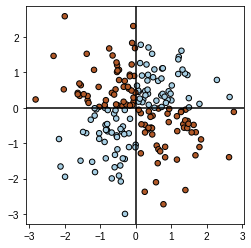

In [12]:
X = jax.random.normal(jax.random.PRNGKey(1234), (200, 2))
y = jnp.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

plt.scatter(
    X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired, edgecolors=(0, 0, 0)
)
plt.gca().set_aspect("equal")
_ = plt.axhline(0, color="k")
_ = plt.axvline(0, color="k")

In [13]:
xs = jnp.linspace(-2, 2, num=100)
ys = jnp.linspace(-2, 2, num=100)

xx, yy = jnp.meshgrid(xs, ys)
xx = xx.T
yy = yy.T
T = jnp.vstack((xx.ravel(), yy.ravel())).T

In [14]:
y_T = jnp.logical_xor(T[:, 0] > 0, T[:, 1] > 0)

In [20]:
def sigmoid(x):
  return 1 / (1 + jnp.exp(-x))

In [21]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.initializers import zeros
import numpyro
import numpyro.distributions as dist
from tinygp import kernels, transforms, GaussianProcess


def model(x, y = None):
    # Set up a typical Squared Exponential kernel

    sigma = numpyro.param("sigma", jnp.ones(), constraint = dist.constraints.positive)
    ell = numpyro.param("ell", jnp.ones(), constraint = dist.constraints.positive)
    jitter = numpyro.param("jitter", jnp.zeros())

    kernel = (sigma ** 2) * kernels.ExpSineSquared(scale = ell)

    # Evaluate and return the GP negative log likelihood as usual
    gp = GaussianProcess(kernel, X, diag=jitter ** 2)

    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())
    log_rate = sigmoid(log_rate)
    numpyro.sample("obs", dist.Bernoulli(jnp.exp(log_rate)), obs = y)


def guide(x, y=None):
    mu = numpyro.param(
        "log_rate_mu", jnp.zeros_like(x) if y is None else jnp.log(y + 1)
    )
    sigma = numpyro.param(
        "log_rate_sigma",
        jnp.ones_like(x),
        constraint=dist.constraints.positive,
    )
    numpyro.sample("log_rate", dist.Independent(dist.Normal(mu, sigma), 1))

In [22]:
optim = numpyro.optim.Adam(0.01)
svi = numpyro.infer.SVI(model, guide, optim, numpyro.infer.Trace_ELBO(10))
results = svi.run(jax.random.PRNGKey(55873), 3000, X, y=y, progress_bar=False)

ValueError: Incompatible shapes for broadcasting: ((1, 1), (1, 200), (200, 2))

In [18]:
mu = results.params["log_rate_mu"]
sigma = results.params["log_rate_sigma"]
plt.plot(x, np.exp(mu), color="C0", label="VI inferred rate")
plt.fill_between(
    x,
    np.exp(mu - 2 * sigma),
    np.exp(mu + 2 * sigma),
    alpha=0.3,
    lw=0,
    color="C0",
)
plt.fill_between(
    x, np.exp(mu - sigma), np.exp(mu + sigma), alpha=0.3, lw=0, color="C0"
)
plt.plot(x, np.exp(true_log_rate), "--", color="C1", label="true rate")
plt.plot(x, y, ".k", label="data")
plt.legend(loc=2)
plt.xlabel("x")
_ = plt.ylabel("counts")

NameError: name 'results' is not defined

In [ ]:
def rounder(x):
    if x <= 0.5:
        return 0
    else:
        return 1

In [ ]:
mean, var = model.apply(params, X, y, X)[1]
y_hat = jnp.array([round(x) for x in mean])

print(f"Accuracy: {(y_hat==y).sum()*100/(len(y)) :0.2f}%")

Accuracy: 98.50%


In [ ]:
mean, var = model.apply(params, X, y, T)[1]
y_hat = jnp.array([round(x) for x in mean])

print(f"Accuracy: {(y_hat==y_T).sum()*100/(len(y_T)) :0.2f}%")

Accuracy: 96.67%


In [ ]:
def plot_pred_2d(arr, xx, yy, contour=False, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = ax.imshow(
        arr,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="equal",
        origin="lower",
        cmap=plt.cm.PuOr_r,
    )
    if contour:
        contours = ax.contour(
            xx,
            yy,
            sigmoid(mean).reshape(xx.shape),
            levels=[0.5],
            linewidths=2,
            colors=["k"],
        )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    ax.get_figure().colorbar(image, cax=cax)
    if title:
        ax.set_title(title)

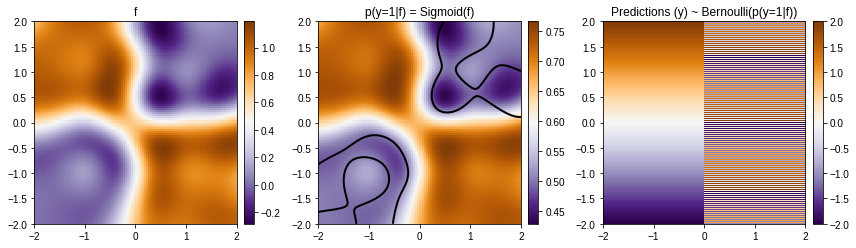

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
plot_pred_2d(mean.reshape(xx.shape), xx, yy, ax=ax[0], title="f")
plot_pred_2d(
    sigmoid(mean).reshape(xx.shape),
    xx,
    yy,
    ax=ax[1],
    title="p(y=1|f) = Sigmoid(f)",
    contour=True,
)
plot_pred_2d(T, xx, yy, ax=ax[2], title="Predictions (y) ~ Bernoulli(p(y=1|f))")

fig.tight_layout()